# 计算机实习题一

### 前面部分给出了几种插值的代码以及对代码的解释，之后是利用前面的代码完成的作业
> 说明：提供的文件包括了jupyter(.ipynb)的代码和导出的.html文件
>  * .html 文件能直接打开预览，和pdf一样，但是pdf会分页，所以使用了html
>  * .ipynb文件能够直接运行，要求python3，以及一些库：
>   * numpy
>   * matplotlib

**导入库**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)

## 几种插值的实现

### 拉格朗日插值

**类说明**
* `X`，`Y`存储了数据，`__L_func`是向量化版本的`__cacu_l`，用于加快计算给定一组数据的拉格朗日插值
* `__cacu_l` 计算了x点处对应的插值函数的值
    * 拉格朗日插值公式：
        <img src="pics/lag_1.PNG" title="拉格朗日插值公式" left="50px">
    * 基函数
        $$l_k = \frac {(x - x_0)(x - x_1)...(x - x_{k-1})(x - x_{k+1})...(x - x_n)} {(x_k - x_0)(x_k - x_1)...(x_k - x_{k-1})(x_k - x_{k+1})...(x_k - x_n)}$$
    * 变量
        * `denominator_mat`：计算了基函数分母部分，表示为矩阵形式
        * `numerator_vec`：计算了基函数分子部分
        * `basic_func`：利用两者相除即得到基函数$l_i$，为向量形式
* 具体实现：
> `LagrangeInterpolation`只提供了`L()`接口，使用时将对应的点序列传入，即能得到对应的插值函数的值

In [2]:
class LagrangeInterpolation:
    '''拉格朗日插值
        Inputs:
            - X: np.ndarray 采样点x
            - Y: np.ndarray 原函数在采样点对应的函数值
    '''
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.__L_func = np.vectorize(self.__cacu_l)
        
    def __cacu_l(self, x):
        # 用于计算采样点x的拉格朗日函数值
        w_vec = x - self.X
        denominator_mat = (self.X.copy().reshape(len(self.X), -1) - self.X) + np.eye(len(self.X))
        numerator_vec = np.array([np.multiply.reduce(x - self.X[:k]) * np.multiply.reduce(x - self.X[k + 1:]) for k in range(len(self.X))])
        basic_func = (numerator_vec) / np.multiply.reduce(denominator_mat, axis=1)
        return np.sum(basic_func * self.Y)
    
    def L(self, x_vec):
        return self.__L_func(x_vec)

### 牛顿插值

**类说明**
* `X`，`Y`存储了数据，通过两遍`diff`(后一项减前一项)可以判断X给出的是否是等差序列，从而判断使用差分形式的牛顿插值还是均差形式的牛顿插值
* 均差形式
    * 课本提供了两种计算方式
        * 利用均差性质一，差分可以表示为函数值的线性组合，实现为`__differenceQuotient_1`
        <img src="pics/newton_1.PNG">
        * 利用均差表计算，实现为`__differenceQuotient_2`,但是这里为了加快计算和节省空间，使用了一维数组存储均差，因此**不能发挥牛顿插值可以动态插入点的特性**，即计算过程中的均差都被覆盖了
    * `__P(x)` 函数通过设置`__tag`为`True`和`False`分别使用上述两种方式计算牛顿插值函数值
    <img src="pics/newton_2.PNG">
* 差分形式
    * `difference` 用于计算`Y`序列的差分，同样使用了一维数组存储，因此和前面有一样的缺点
    * `P_diff(x)` 函数使用差分计算牛顿插值函数值
    <img src="pics/newton_3.PNG">
* 和拉格朗日插值一样，将`__P`和`P_diff`向量化，从而可以进行快速计算
* 具体实现：
> `Newton`只提供了`P()`接口，使用时将对应的点序列传入，即能得到对应的插值函数的值

In [3]:
class Newton:
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        if np.any(np.diff(np.diff(X))): #  判断是否是等差
            self.P_func = np.vectorize(self.__P)
        else:
            self.P_func = np.vectorize(self.P_diff)
            
    def difference(self):
        '''计算Y的差分序列
            - 使用一维数组存储差分
        '''
        diff = np.array(self.Y)
        for i in range(1, len(self.Y)):
            diff[i:] = diff[i:] - diff[i - 1:-1]
        return diff
    
    def P_diff(self, x):
        '''使用差分计算插值函数的值P(x)
        '''
        t = (x - self.X[0]) / (self.X[1] - self.X[0])
        consts = np.array([t-1] + [i for i in range(len(self.X) - 1)])
        x_prod = np.cumprod(t - consts)
        x_divid = np.cumprod([1] + [i for i in range(1, len(self.X))])
        return np.sum(x_prod * self.difference() / x_divid)
        
    def __differenceQuotient_1(self, i):
        '''计算 f[x0,x1,...xi]
            - 使用均差基本性质1，可以表示为函数值线性组合计算
        '''
        i += 1
        diffQuo = 0
        for k in range(0, i):
            diffQuo += self.Y[k] / (np.multiply.reduce(self.X[k] - self.X[0:k]) * np.multiply.reduce(self.X[k] - self.X[k + 1: i]))
        return diffQuo
    
    def __differenceQuotient_2(self):
        '''计算 f[x0,x1,...xi]
            - 使用均差表计算
        '''
        diffQuo = np.array(self.Y)
        deta_x = None
        for i in range(1, len(self.X)):
            deta_x = self.X[i:] - self.X[:-i]
            diffQuo[i:] = (diffQuo[i:] - diffQuo[i-1:-1]) / deta_x
        return diffQuo

    def __P(self, x, __tag=True):
        '''使用均差计算插值函数的值P(x)
        '''
        if not __tag:
            diffQuot = np.vectorize(self.__differenceQuotient_1)([i for i in range(len(self.X))])
        else:
            diffQuot = self.__differenceQuotient_2()
        x_prod = np.cumprod(x - np.concatenate((np.array([x-1, ]), self.X[:-1])))
        return np.sum(x_prod * diffQuot)
    
    def P(self, x_vec):
        '''向量化的P(x)，用于加快计算
        '''
        return self.P_func(x_vec)

###  三次样条插值

**类说明**
* `X`，`Y`存储了数据。课本给出的解答中，使用了矩阵进行求解，编程实现的难点在于对不同的边界条件确定不同的系数矩阵，这个步骤难以优化，只能通过判断进行数值填充
* `H`,`M` 为公式中大写字母均表示向量。矩阵的构造：
    * 边界条件：
        * 第一，二类边条需要求解的公式：<img src="pics/cubic_1.PNG">
            * 第一类边界条件的**case=1**，额外的条件：
                <img src="pics/cubic_2.PNG">
            * 第二类边界条件的**case=2**,额外的条件：
                <img src="pics/cubic_3.PNG">
        * 第三类边界条件：题目没有涉及，因此第三类先放空
    * 结合边界条件以及代数式的计算方式：<img src="pics/cubic_4.PNG">
        构造三对角矩阵A
* 使用`np.linalg.solve`求解方程，得到**M**
* 得到**M**后使用*S(x)*的公式直接进行求解，实现在`__S`函数中
    <img src="pics/cubic_5.PNG">
* 具体实现：
> `CubicInterpolation`只提供了`S()`接口，使用时将对应的点序列传入，即能得到对应的插值函数的值

In [4]:
class CubicInterpolation:
    
    def __init__(self, X, Y, case, param):
        self.X = X
        self.Y = Y
        self.H = None
        self.M = None
        self.case = case
        self.param = param
        self.__cacu_M()
        self.__S_func = np.vectorize(self.__S)
    
    def __cacu_M(self):
        self.H = X[1:] - X[:-1]                                # n-1 dimentions
        U = self.H[:-1] / (self.H[:-1] + self.H[1:])           # n-2 dimentions
        Lambda = self.H[1:] / (self.H[:-1] + self.H[1:])       #  n-2 dimentions
        Diff = (Y[1:] - Y[:-1]) / (X[1:] - X[:-1])             #  n-1 dimentions
        D = 6 * (Diff[1:] - Diff[:-1]) / (self.H[:-1] + self.H[1:]) # n-2 dimentions
        #  边界条件
        if self.case == -1:
            return None # error
        # 在前两种情况下，线性方程组的的阶为 n+1
        if self.case == 1:
            lamb0 = 1
            un = 1
            d0 = (6 / self.H[0]) * (Diff[0] - self.param["f_deta_1_0"])
            dn = (6 / self.H[-1]) * (self.param["f_deta_1_n"]  - Diff[-1])
        if self.case == 2:
            lamb0 = un = 0
            d0 = 2 * self.param["f_deta_2_0"]
            dn = 2 * self.param["f_deta_2_n"]
        # 根据边界条件补充完 U，lambda，D 
        U = np.concatenate((U, [un]))
        Lambda = np.concatenate(([lamb0], Lambda)) #  add lambda_0
        D = np.concatenate(([d0], D, [dn])).T
        # 构造三对角矩阵
        A = 2. * np.eye(len(X)) + np.diag(Lambda, 1) + np.diag(U, -1) # 系数矩阵
        self.M = np.linalg.solve(A, D)
        # 在最后一种边界条件下，线性方程的阶为 n
        if self.case == 3:
                pass
    
    def __S(self, x):
        if(x < self.X[0] or x > self.X[-1]):
            return None
        for i in range(len(self.X)):
            if self.X[i + 1] >= x:
                a = self.M[i] * ((self.X[i + 1] - x)**3 / (6 * self.H[i]))
                b = self.M[i + 1] * ((x - self.X[i])**3 / (6 * self.H[i]))
                c = (self.Y[i] - ((self.M[i] * self.H[i]**2) / 6)) * ((self.X[i + 1] - x) / self.H[i])
                d = (self.Y[i + 1] - ((self.M[i + 1] * self.H[i]**2) / 6)) * ((x - self.X[i]) / self.H[i])
                return (a + b + c + d)
    
    def S(self, x_vec):
        return self.__S_func(x_vec)

## 可视化

> 三种插值函数的调用基本一致，因而实现一个类专门用于画图
> * 类中的两个函数都接受`X`，而`Y`部分则可以为数据点或者是函数(指针)

In [5]:
class Visualizer:
    
    def __init__(self):
        pass
    @staticmethod
    def plot_x_y(x, y, title="x-y", x_lable='x', y_label='y'):
        '''画出 x-y 图
        '''
        fig, ax = plt.subplots()
        ax.plot(x, y)
        ax.set(xlabel, ylabel,title)
        ax.grid()
        plt.show()
        
    @staticmethod
    def plot_x_func(x, y, title="x-y", x_label='x', y_label='y'):
        '''画出 x-y(x)图
        '''
        fig, ax = plt.subplots()
        ax.plot(x, y(x))
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
        ax.grid()
        plt.show()
        
#     @staticmethod
#     def scatter_x_func(x, y, title="x-y", x_label='x', y_label='y'):
#         '''画出 x-y(x)点图
#         '''
#         fig, ax = plt.subplots()
#         ax.scatter(x, y(x))
#         ax.set(xlabel=x_label, ylabel=y_label, title=title)
#         ax.grid()
#         plt.show()
        
    @staticmethod
    def plot_x_func_ax(ax, x, y, title="x-y", x_label='x', y_label='y'):
        '''画出 x-y(x)图
        '''
        ax.plot(x, y(x))
        ax.set(xlabel=x_label, ylabel=y_label, title=title)
        ax.grid()
        
    @staticmethod
    def scatter_x_func_ax(ax, x, y, title="x-y", x_label='x', y_label='y', tag=True):
        '''画出 x-y(x)点图
        '''
        ax.scatter(x, y(x))
        if tag:
            for xy in zip(x, y(x)):
                ax.annotate("(%s,%s)" % xy, xy=xy, xytext=(-2, 1), textcoords='offset points')
        
    @staticmethod
    def plot_x_funcs_ax(ax, x, Y, labels, title, x_label="x"):
        for i in range(len(Y)):
            ax.plot(x, Y[i](x), label=labels[i])
        ax.set(xlabel=x_label, title=title)
        ax.grid()
        ax.legend()

### 测试

#### 三次样条
> 利用课本例题的数据进行测试

In [6]:
X = np.array([27.7, 28, 29, 30])
Y = np.array([4.1, 4.3, 4.1, 3.0])
param = {
    "f_deta_1_0": 3,
    "f_deta_1_n": -4
}

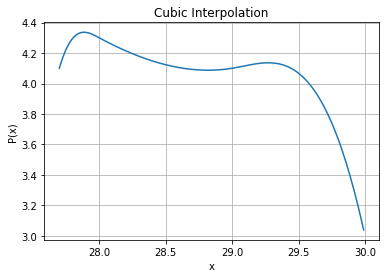

In [7]:
cubI = CubicInterpolation(X, Y, 1, param)
test_x = np.arange(X[0], X[-1], 0.01)
Visualizer.plot_x_func(test_x, cubI.S, title="Cubic Interpolation", y_label='P(x)')

#### 牛顿插值
> 利用课本例题的数据进行测试

In [8]:
X = np.array([0, 1, 2, 3, 4, 5]) / 10
Y = np.array([1, 0.995, 0.98007, 0.95534, 0.92106, 0.87758])

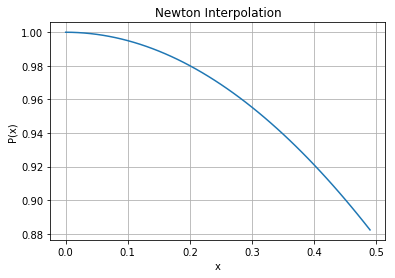

In [9]:
nt = Newton(X, Y)
test_x = np.arange(X[0], X[-1], 0.01)
Visualizer.plot_x_func(test_x, nt.P, title="Newton Interpolation", y_label='P(x)')

## 课本题目

### 一. 已知函数以及值 
| $$x_i$$ | 0.2 | 0.4 | 0.6 | 0.8 | 1.0 |  
| :------| ------: | :------: | :------: | :------: | :------: |  
| $$f(x_i)$$ | 0.98 | 0.92 | 0.81 | 0.64 | 0.38 |  

  1. 四次牛顿插值多项式
  2. 三次样条函数
> 数据以及题目要求画出来的数据点
> * `param` 为三次样条插值需要的自然边条
> * `test_x` 为画图所需的`x`的数据

In [10]:
X = np.array([.2, .4, .6, .8, 1.])
Y = np.array([.98, .92, .81, .64, .38])
X_test = np.array([0.2 + 0.08 * i for i in [0, 1, 11, 10]])
test_x = np.arange(X[0], X[-1] + 0.001, 0.01)

In [11]:
param = {
    "f_deta_2_0": 0,
    "f_deta_2_n": 0
}

 **初始化两种插值的类，经过初始化步骤，按类部分的说明已经生成对应的插值函数**

In [12]:
nt = Newton(X, Y)

In [13]:
cubI = CubicInterpolation(X, Y, 2, param)

**画图**
> 前两张为对应$P_4(x)$以及$S(x)$的图形，包括要求的四个点，最后一张为两个函数画在同一张图上，仔细看会有区别  
> **如果运行.pynb文件可以双击得到大图**

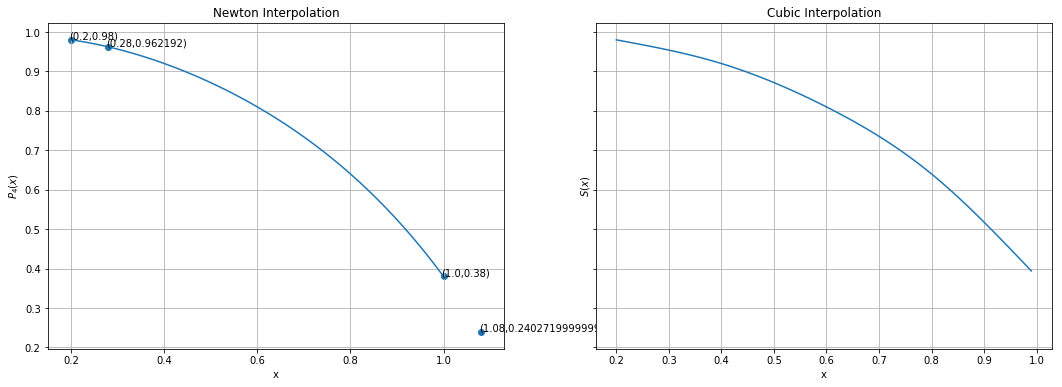

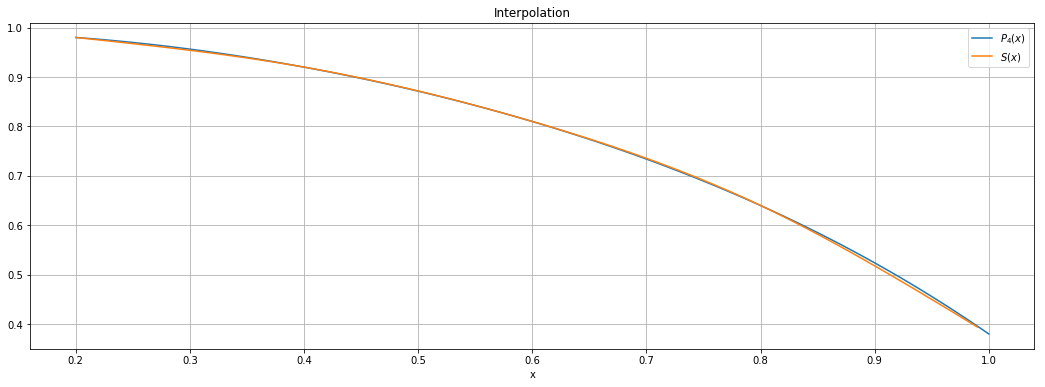

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
Visualizer.plot_x_func_ax(axs[0], test_x, nt.P, title="Newton Interpolation", y_label="$P_4(x)$")
Visualizer.scatter_x_func_ax(axs[0], X_test, nt.P)
Visualizer.plot_x_func_ax(axs[1], test_x, cubI.S, title="Cubic Interpolation", y_label="$S(x)$")
#Visualizer.scatter_x_func_ax(axs[1], X_test, cubI.S)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(18, 6), sharey=True)
Visualizer.plot_x_funcs_ax(axs, test_x, [nt.P, cubI.S], labels=["$P_4(x)$", "$S(x)$"], title="Interpolation")
plt.show()

> 其中，对于超出范围的x，样条函数返回Non

In [15]:
cubI.S(X_test) 

array([0.98  , 0.9596,    nan, 0.38  ])

### 二. 龙格函数插值 
> 对龙格函数分别做N=10,20的采样，然后分别进行多项式和样条插值

-  生成数据点，并绘出数据点

In [16]:
N = [10, 20]
def rungeFunc(x):
    return 1. / (1 + 25 * x**2)

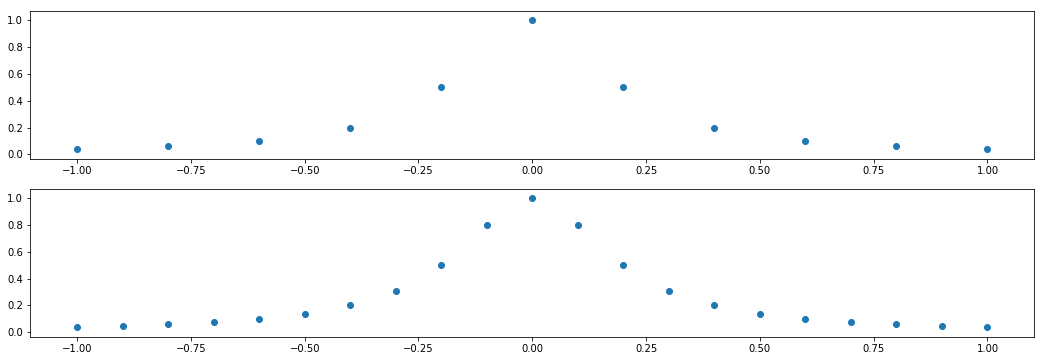

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(18, 6), sharey=True)
X = []
Y = []
for i in range(len(N)):
    X.append(np.arange(-1, 1+0.001, 2. / N[i]))
    Y.append(rungeFunc(X[i]))
    Visualizer.scatter_x_func_ax(axs[i], X[i], rungeFunc, title="Runge Funtion", y_label="$P_4(x)$", tag=False)
plt.show()

**三次样条插值，题目没有要求边界条件，这里使用了自然边条**

In [18]:
param = {
    "f_deta_2_0": 0,
    "f_deta_2_n": 0
}

**对两组数据，分别进行插值，过程和第一题类似**

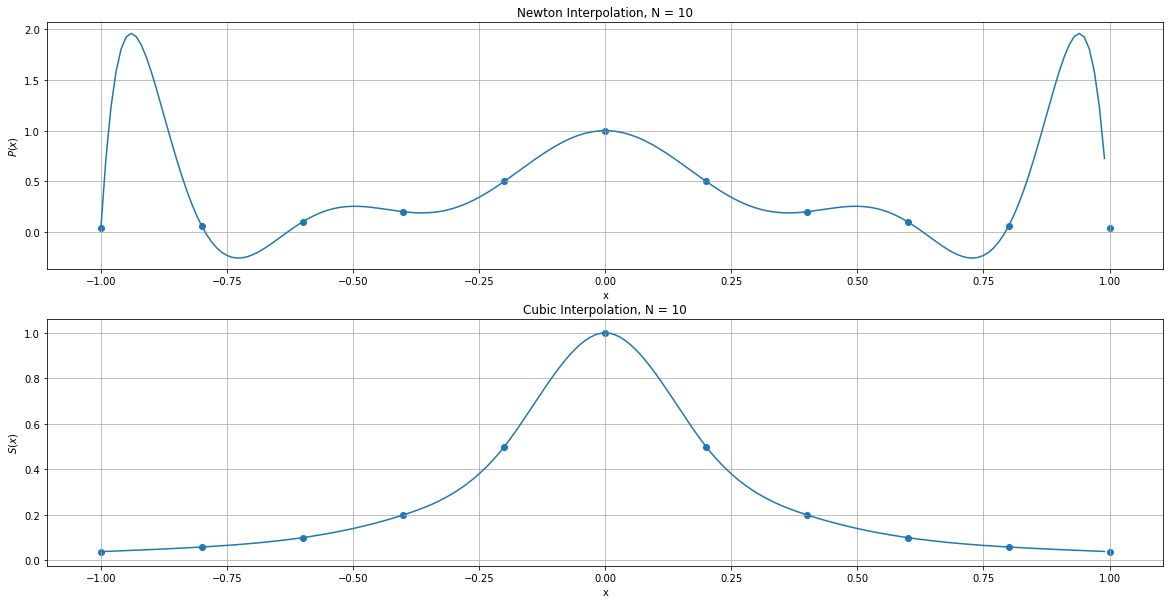

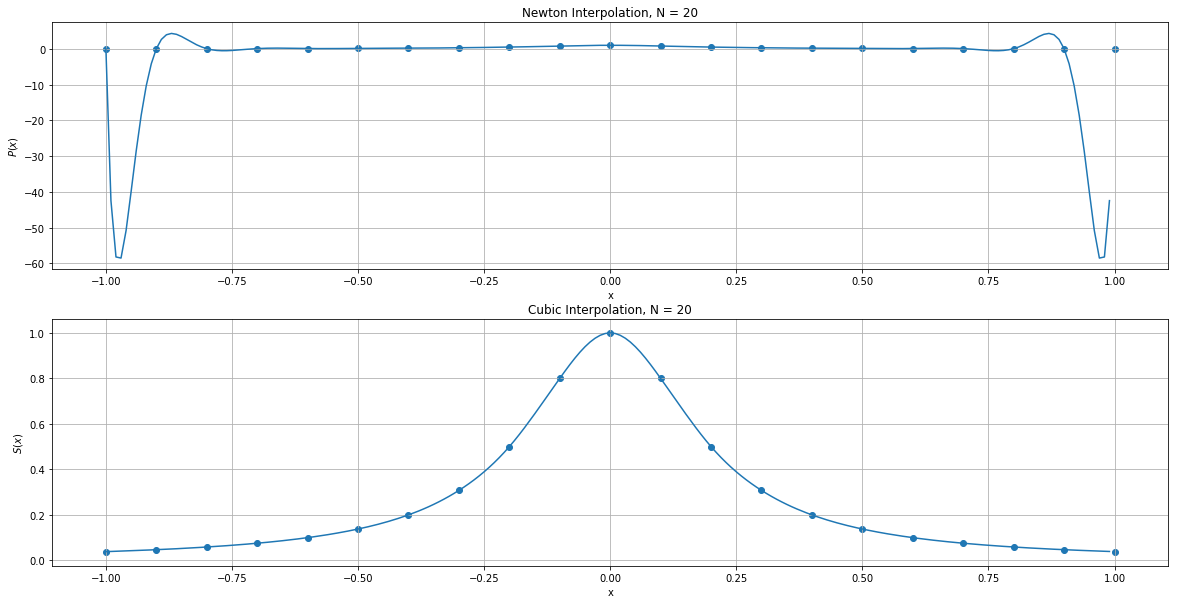

In [19]:
for i in range(len(N)):
    # 生成数据
    X = np.arange(-1, 1+0.001, 2. / N[i])
    Y = rungeFunc(X)
    # 构造插值函数类
    nt = Newton(X, Y)
    cubI = CubicInterpolation(X, Y, 2, param)
    # 绘图
    test_x = np.arange(X[0], X[-1], 0.01)
    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    Visualizer.plot_x_func_ax(axs[0], test_x, nt.P, title="Newton Interpolation, N = {}".format(N[i]), y_label="$P(x)$")
    Visualizer.scatter_x_func_ax(axs[0], X, nt.P, tag=False)
    Visualizer.plot_x_func_ax(axs[1], test_x, cubI.S, title="Cubic Interpolation, N = {}".format(N[i]), y_label="$S(x)$")
    Visualizer.scatter_x_func_ax(axs[1], X, nt.P, tag=False)
    plt.show()

### 三. 对数据点插值 
| $$x_i$$ | 0 | 1 | 4 | 9 | 16 | 25 | 36 | 49 | 64 |  
| :------| ------: | :------: | :------: | :------: | :------: | :------: | :------: | :------: | :------: |
| $$f(x_i)$$ | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 

In [20]:
X = np.array([1, 2, 4, 9, 16, 25, 36, 49, 64])
Y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
test_x = np.arange(X[0], X[-1] + 0.001, 0.01)

> **(1).拉格朗日插值**

In [21]:
laInt = LagrangeInterpolation(X, Y)

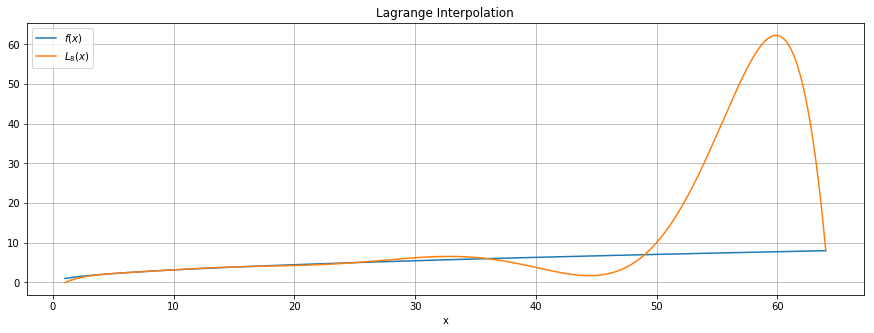

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
Visualizer.plot_x_funcs_ax(ax, test_x, [lambda x:x**(1/2), laInt.L], labels=["$f(x)$", "$L_8(x)$"], title="Lagrange Interpolation")

> **2.三次样条插值**
> * 题目要求使用第一边界条件，但是平方根函数在0处导数为无穷大， 若**用大一点的导数值代入就会出现震荡**

In [23]:
# 可以表示的最大数
import sys
sys.float_info.max

1.7976931348623157e+308

**导数值100**

In [24]:
param = {
    "f_deta_1_0":100,
    "f_deta_1_n":1./16
}
cubI = CubicInterpolation(X, Y, 1, param)

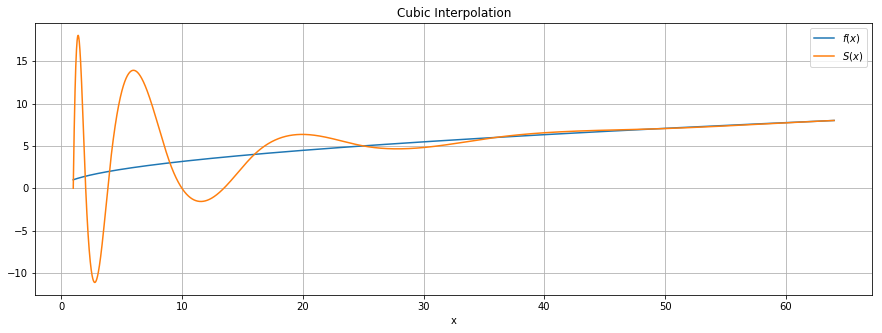

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
Visualizer.plot_x_funcs_ax(ax, test_x, [lambda x:x**(1/2), cubI.S], labels=["$f(x)$", "$S(x)$"], title="Cubic Interpolation")

**导数值小一些**

In [26]:
param = {
    "f_deta_1_0":1,
    "f_deta_1_n":1./16
}
cubI = CubicInterpolation(X, Y, 1, param)

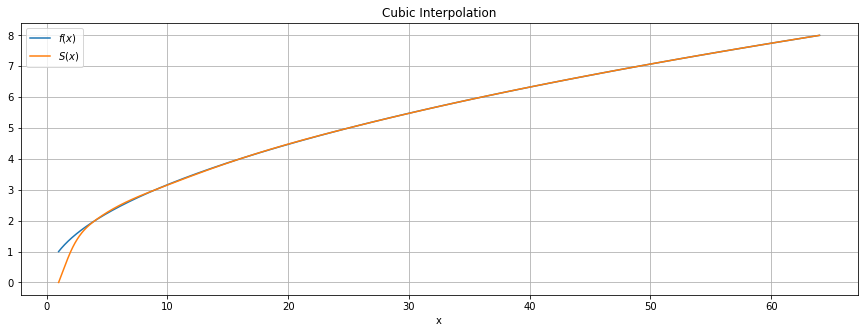

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
Visualizer.plot_x_funcs_ax(ax, test_x, [lambda x:x**(1/2), cubI.S], labels=["$f(x)$", "$S(x)$"], title="Cubic Interpolation")

> 从结果上看，如果在0处的导数值不取得太大，三次样条会比较精确，在[0,1]区间是拉格朗日插值更加精确